Problem: 

In this project, we look into various health metrics from __heart patients__, including age, blood pressure, heart rate, and more.The goal is to develop a predictive model capable of accurately identifying individuals with heart disease. Given the grave implications of missing a positive diagnosis, our primary emphasis is on ensuring that the model identifies all potential patients, making recall for the positive class a crucial metric.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
# Set the resolution of the plotted figures
plt.rcParams['figure.dpi'] = 200

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

In [3]:
# Read dataset
df = pd.read_csv('heart.csv')
df 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


| __age__ | Age of the patient in years |
| __sex__ | Gender of the patient (0 = male, 1 = female) |
| __cp__ | Chest pain type: <br> 0: Typical angina <br> 1: Atypical angina <br> 2: Non-anginal pain <br> 3: Asymptomatic |
| __trestbps__ | Resting blood pressure in mm Hg |
| __chol__ | Serum cholesterol in mg/dl |                     
| __fbs__ | Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false) |
| __restecg__ | Resting electrocardiographic results: <br> 0: Normal <br> 1: Having ST-T wave abnormality <br> 2: Showing probable or definite left ventricular hypertrophy |  
| __thalach__ | Maximum heart rate achieved during a stress test |                      
| __exang__ | Exercise-induced angina (1 = yes, 0 = no) |
| __oldpeak__ | ST depression induced by exercise relative to rest |
| __slope__ | Slope of the peak exercise ST segment: <br> 0: Upsloping <br> 1: Flat <br> 2: Downsloping |                      
| __ca__ | Number of major vessels (0-4) colored by fluoroscopy |              
| __thal__ | Thalium stress test result: <br> 0: Normal <br> 1: Fixed defect <br> 2: Reversible defect <br> 3: Not described  |
| __target__ | Heart disease status (0 = no disease, 1 = presence of disease) |

In [4]:
# Display a summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


The dataset consists of __303 entries__, ranging from index 0 to 302.   
There are __14 columns__ in the dataset corresponding to various attributes of the patients and results of tests.
Most of the columns (13 out of 14) are of the __int64__ data type.
Only the oldpeak column is of the float64 data type.
There don't appear to be any missing values in the dataset as each column has 303 non-null entries.

Based on the data types and the feature explanations we had earlier, we can see that __9 columns__ (`sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`, and `target`) are indeed __numerical__ in terms of data type, but __categorical__ in terms of their semantics.
 These features should be converted to string (__object__) data type for proper analysis and interpretation:

In [5]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

Let's delve into the summary statistics for our __numerical__ attributes:

In [8]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


* __`age`__: The average age of the patients is approximately 54.4 years, with the youngest being 29 and the oldest 77 years.
* __`trestbps`__: The average resting blood pressure is about 131.62 mm Hg, ranging from 94 to 200 mm Hg.
* __`chol`__: The average cholesterol level is approximately 246.26 mg/dl, with a minimum of 126 and a maximum of 564 mg/dl.
* __`thalach`__: The average maximum heart rate achieved is around 149.65, with a range from 71 to 202.
* __`oldpeak`__: The average ST depression induced by exercise relative to rest is about 1.04, with values ranging from 0 to 6.2.

Afterward, let's look at the summary statistics of the categorical features:

In [10]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
sex,303,2,1,207
cp,303,4,0,143
fbs,303,2,0,258
restecg,303,3,1,152
exang,303,2,0,204
slope,303,3,2,142
ca,303,5,0,175
thal,303,4,2,166
target,303,2,1,165


* __`sex`__: There are two unique values, with males (denoted as 0) being the most frequent category, occurring 207 times out of 303 entries.
* __`cp`__: Four unique types of chest pain are present. The most common type is "__0__", occurring 143 times.
* __`fbs`__: There are two categories, and the most frequent one is "__0__" (indicating fasting blood sugar less than 120 mg/dl), which appears 258 times.
* __`restecg`__: Three unique results are present. The most common result is "__1__", appearing 152 times.
* __`exang`__: There are two unique values. The most frequent value is "__0__" (indicating no exercise-induced angina), which is observed 204 times.
* __`slope`__: Three unique slopes are present. The most frequent slope type is "__2__", which occurs 142 times.
* __`ca`__: There are five unique values for the number of major vessels colored by fluoroscopy, with "__0__" being the most frequent, occurring 175 times.
* __`thal`__: Four unique results are available. The most common type is "__2__" (indicating a reversible defect), observed 166 times.
* __`target`__: Two unique values indicate the presence or absence of heart disease. The value "__1__" (indicating the presence of heart disease) is the most frequent, observed in 165 entries.

1. Univariate Analysis: Here, we'll focus on one feature at a time to understand its distribution and range.
2. Bivariate Analysis: In this step, we'll explore the relationship between each feature and the target variable. This helps us figure out the importance and influence of each feature on the target outcome.
With these two steps, we aim to gain insights into the individual characteristics of the data and also how each feature relates to our main goal: __predicting the target variable__.

We undertake univariate analysis on the dataset's features, based on their datatype:
For continuous data: We employ histograms to gain insight into the distribution of each feature. This allows us to understand the central tendency, spread, and shape of the dataset's distribution.
For categorical data: Bar plots are utilized to visualize the frequency of each category. This provides a clear representation of the prominence of each category within the respective feature.

By employing these visualization techniques, we're better positioned to understand the individual characteristics of each feature in the dataset.

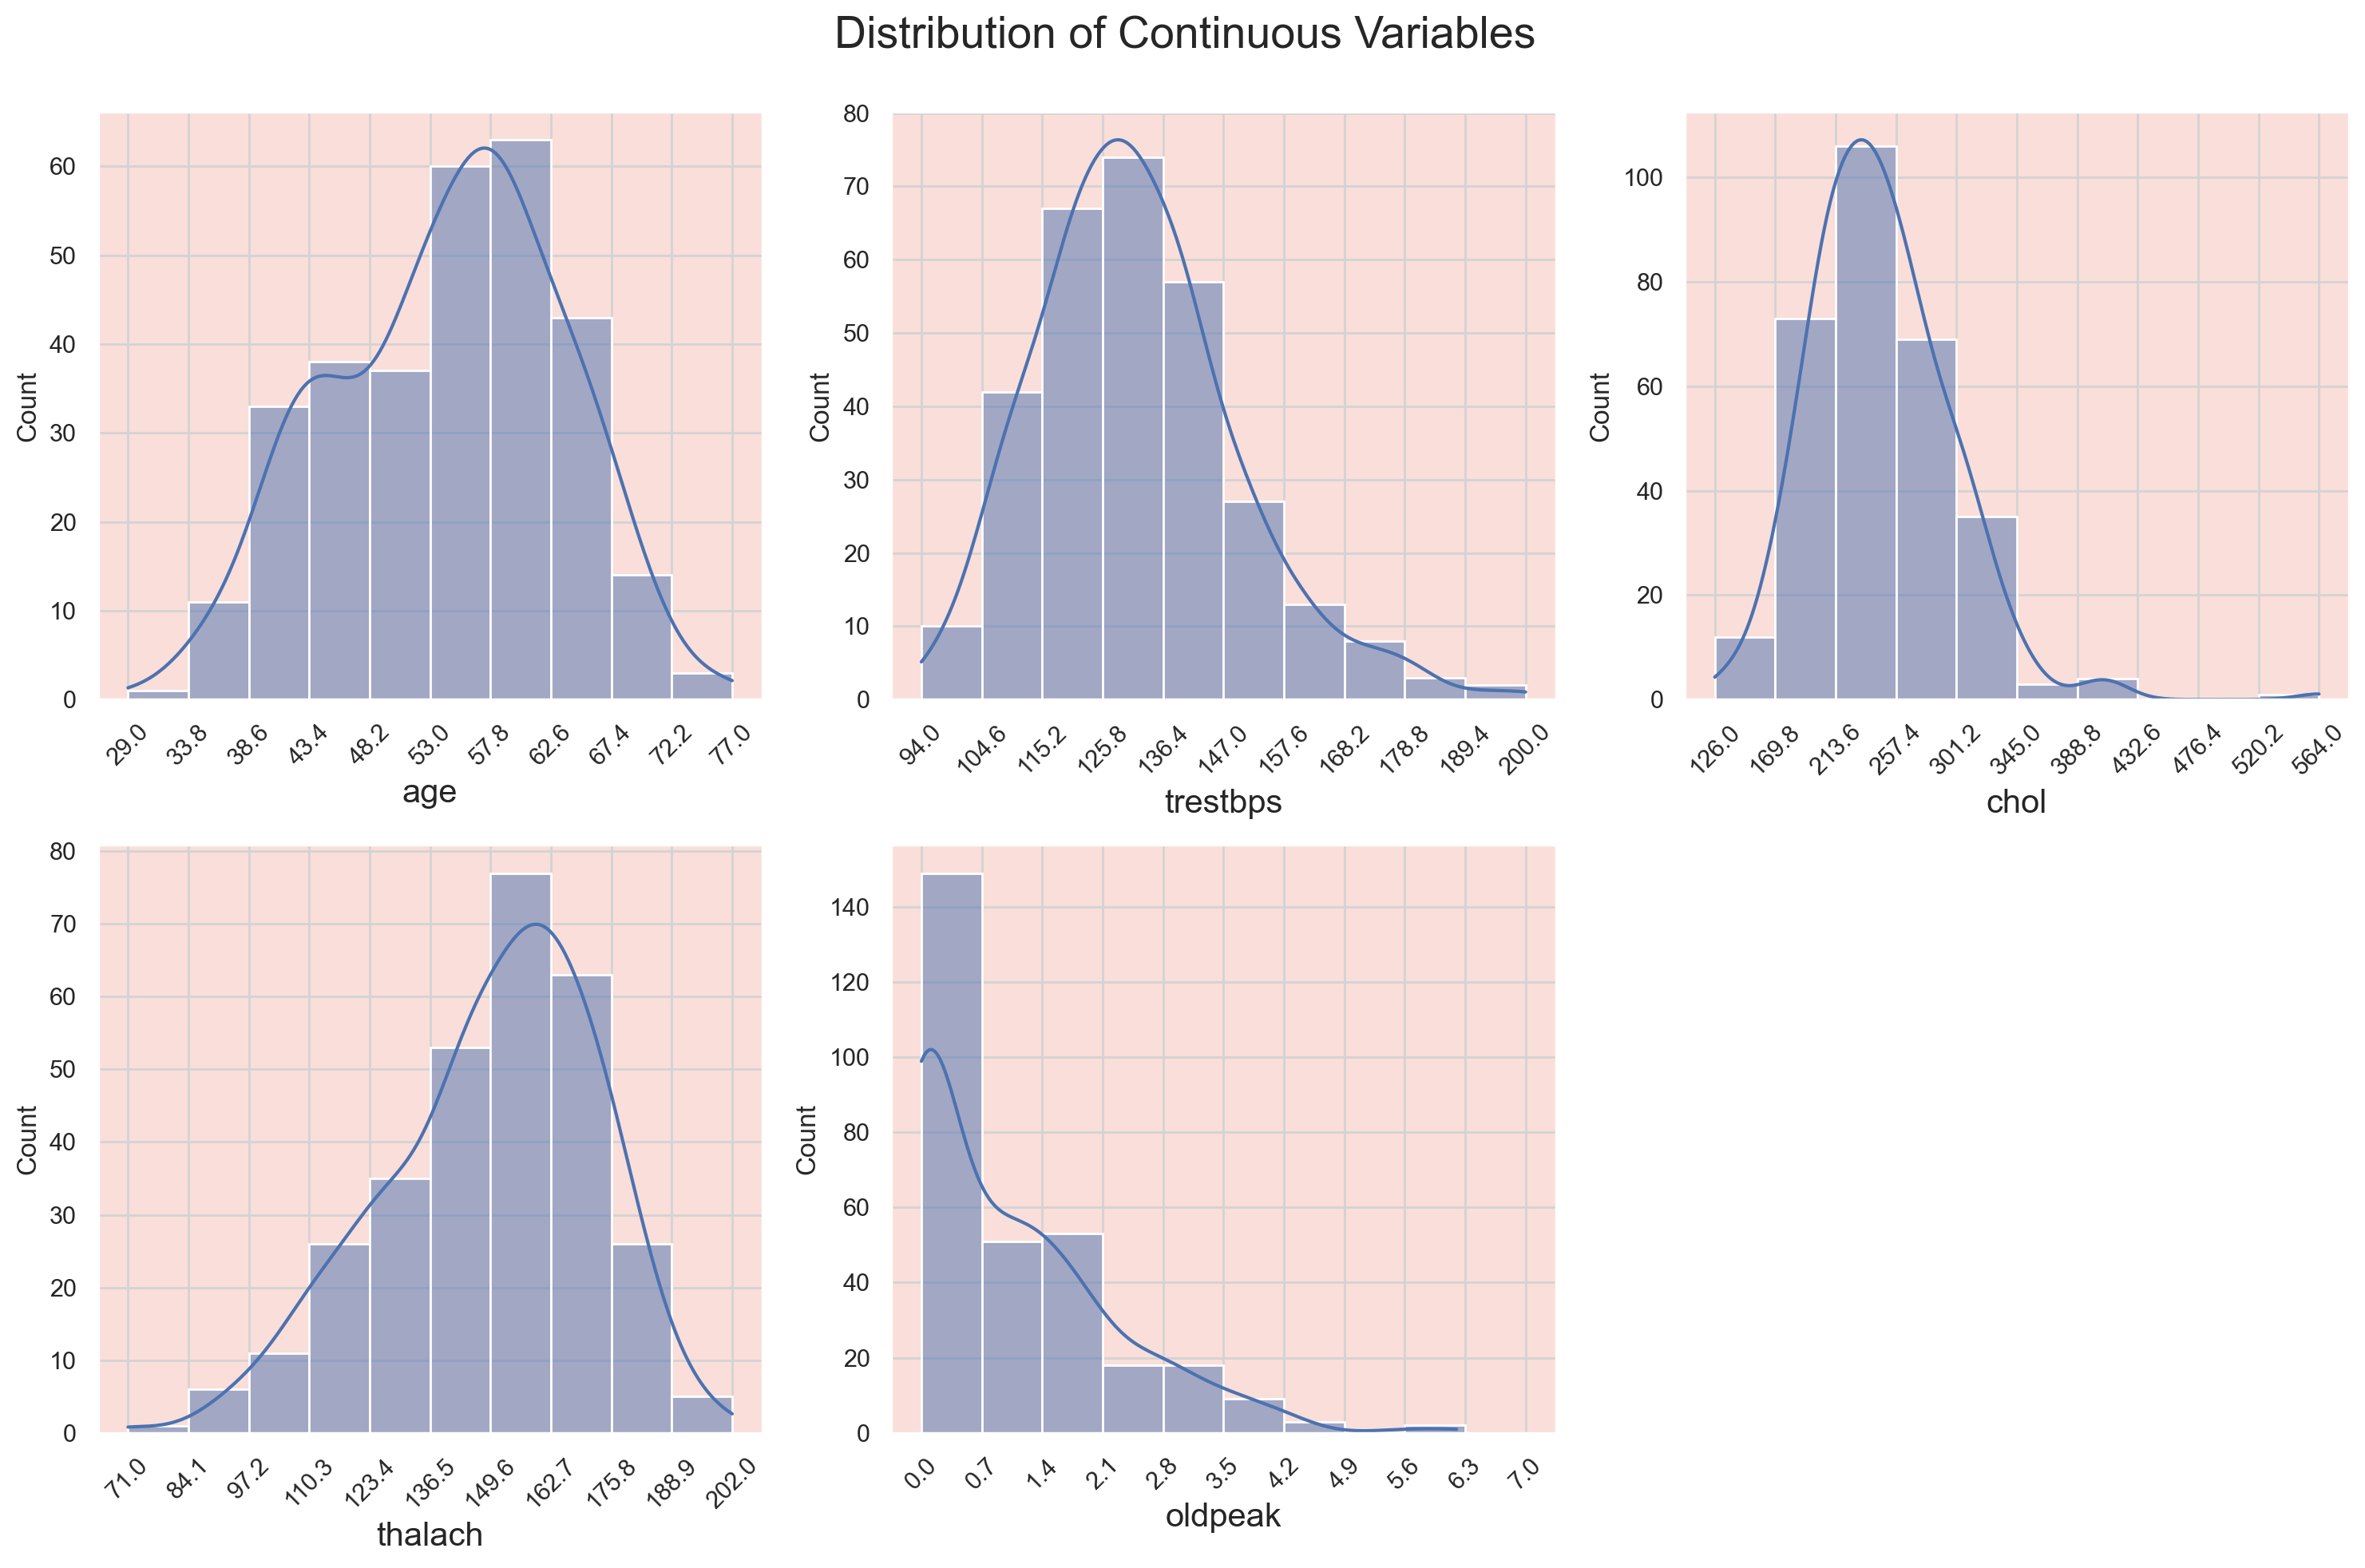

In [22]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y])

    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')



ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

 __Age (`age`)__: The distribution is somewhat uniform, but there's a peak around the late 50s. The mean age is approximately 54.37 years with a standard deviation of 9.08 years.
__Resting Blood Pressure (`trestbps`)__: The resting blood pressure for most individuals is concentrated around 120-140 mm Hg, with a mean of approximately 131.62 mm Hg and a standard deviation of 17.54 mm Hg.
__Serum Cholesterol (`chol`)__: Most individuals have cholesterol levels between 200 and 300 mg/dl. The mean cholesterol level is around 246.26 mg/dl with a standard deviation of 51.83 mg/dl.
 __Maximum Heart Rate Achieved (`thalach`)__: The majority of the individuals achieve a heart rate between 140 and 170 bpm during a stress test. The mean heart rate achieved is approximately 149.65 bpm with a standard deviation of 22.91 bpm.
__ST Depression Induced by Exercise (`oldpeak`)__: Most of the values are concentrated towards 0, indicating that many individuals did not experience significant ST depression during exercise. The mean ST depression value is 1.04 with a standard deviation of 1.16.

Upon reviewing the histograms of the continuous features and cross-referencing them with the provided feature descriptions, everything appears consistent and within expected ranges. 
There doesn't seem to be any noticeable noise or implausible values among the continuous variables.

In [23]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

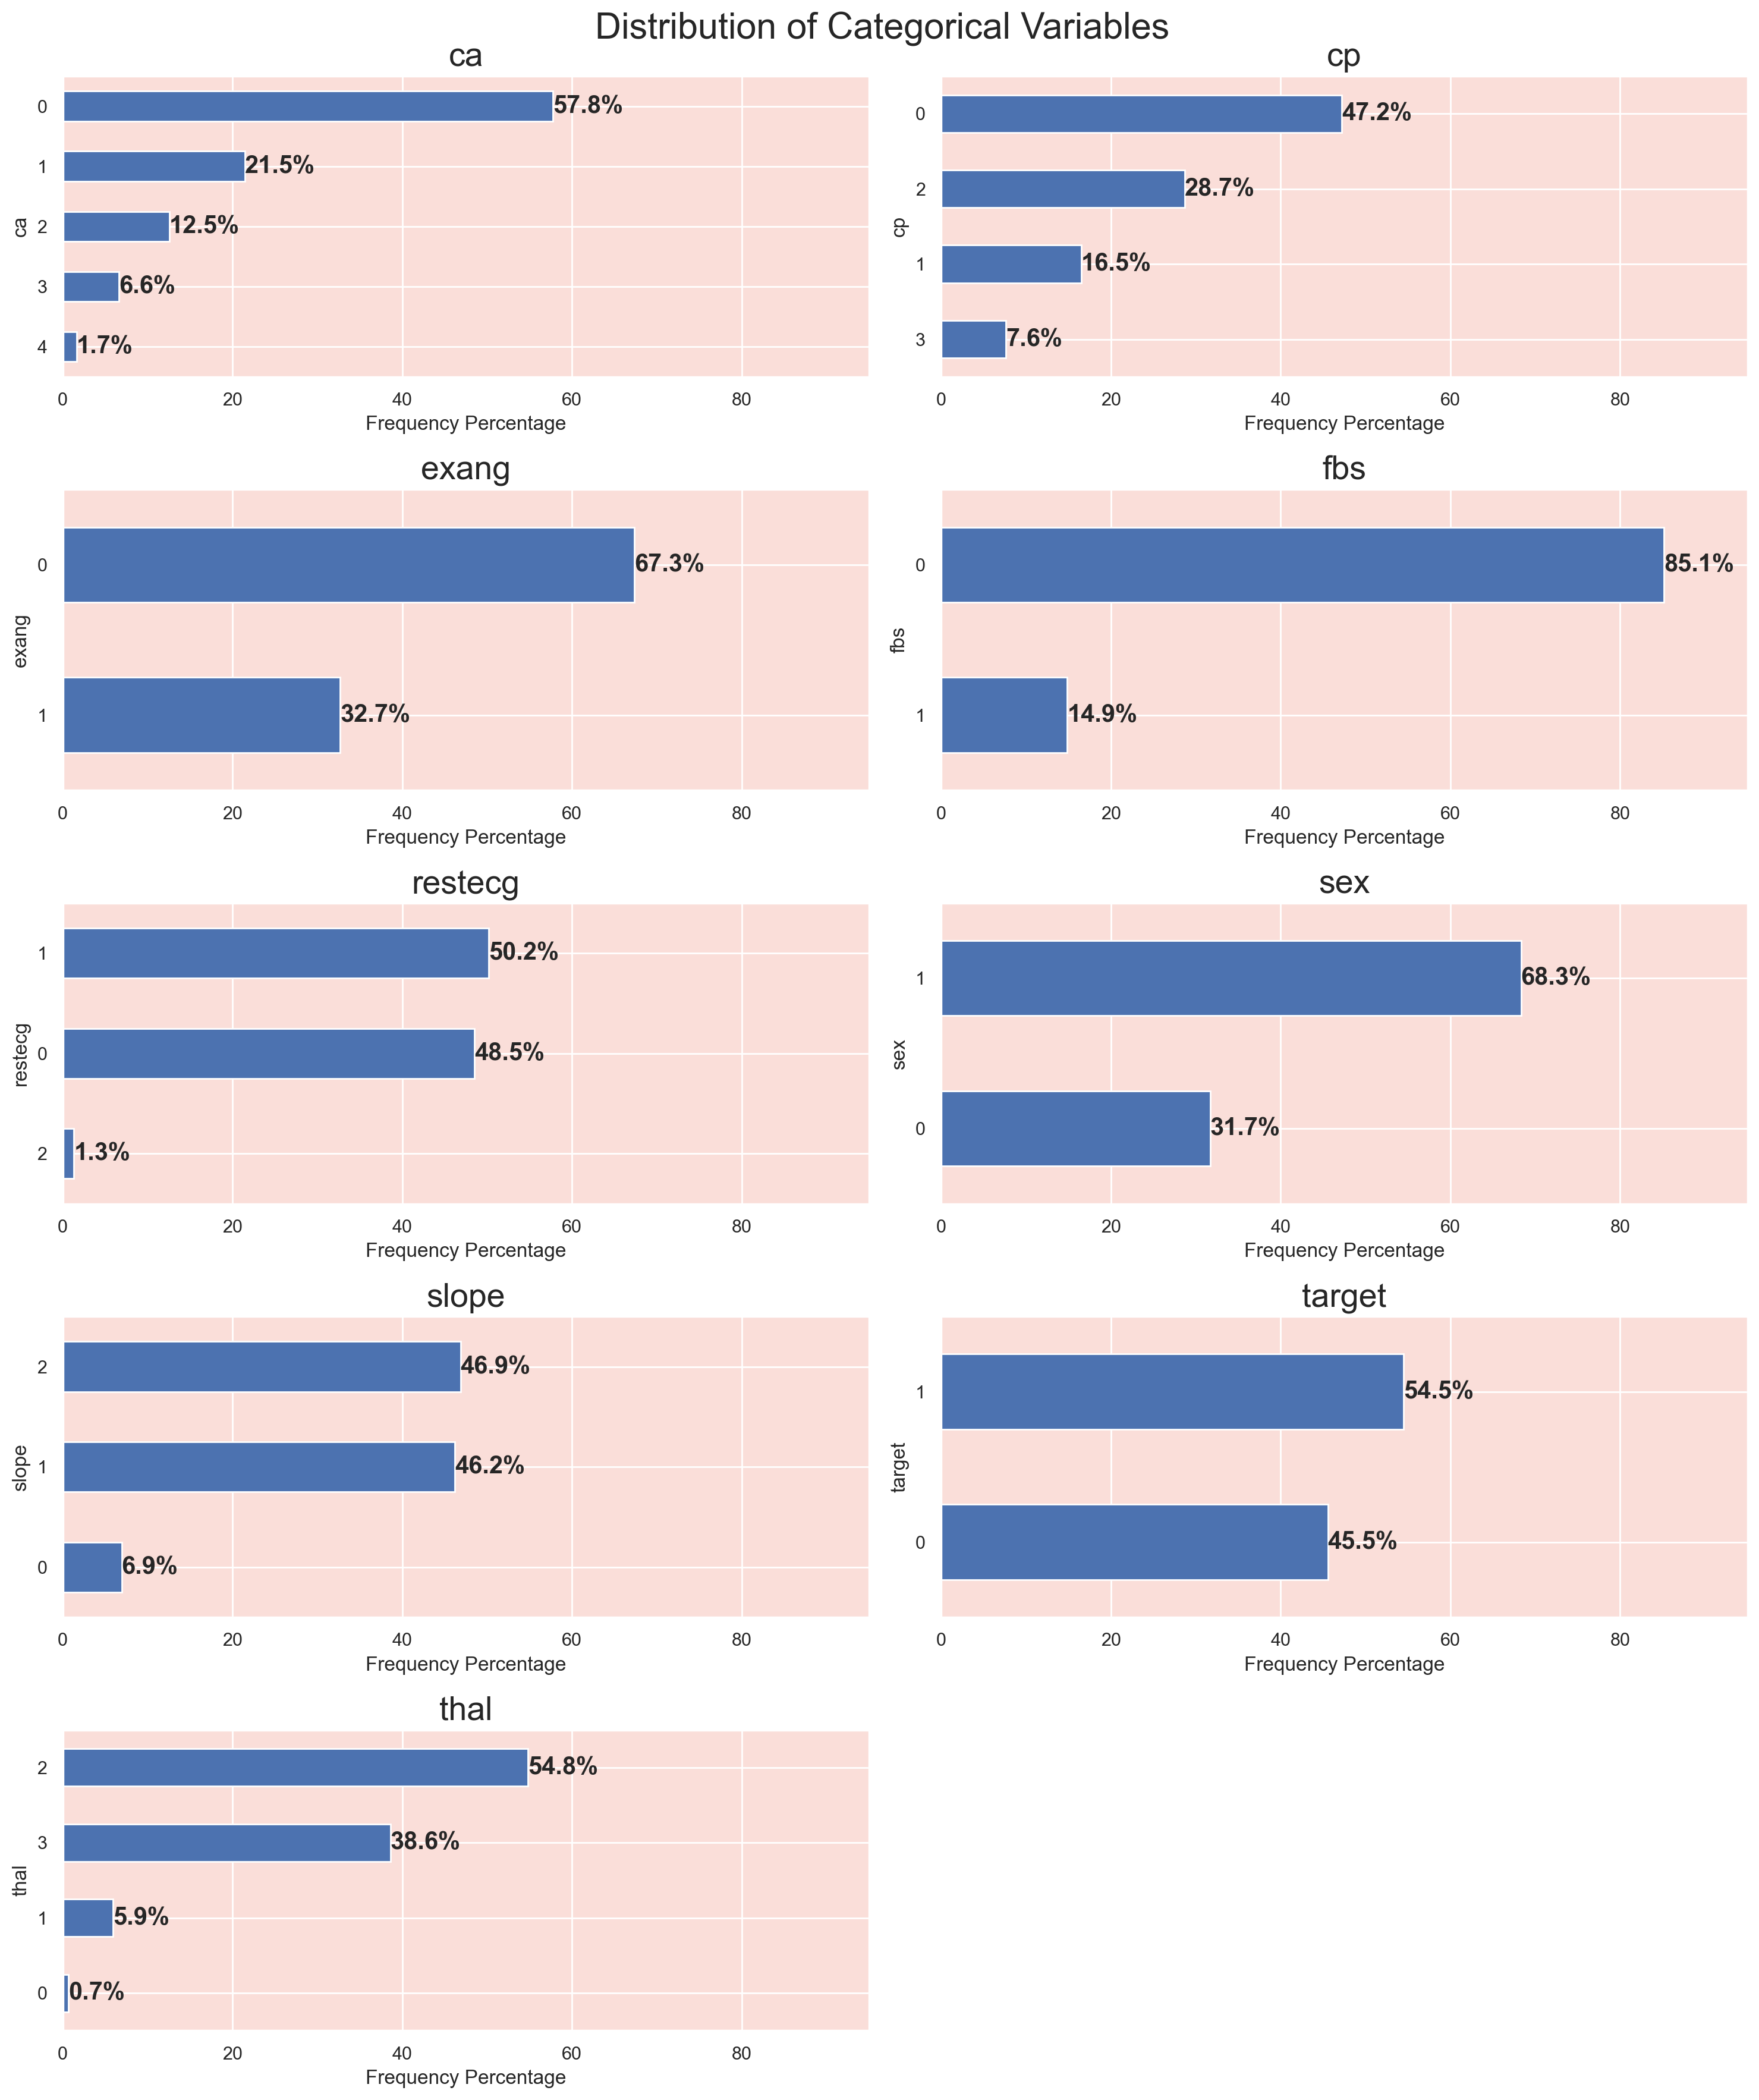

In [28]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.5)
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

 __Gender (`sex`)__: The dataset is predominantly female, constituting a significant majority.
 __Type of Chest Pain (`cp`)__: The dataset shows varied chest pain types among patients. Type 0 (Typical angina) seems to be the most prevalent, but an exact distribution among the types can be inferred from the bar plots.
 __Fasting Blood Sugar (`fbs`)__: A significant majority of the patients have their fasting blood sugar level below 120 mg/dl, indicating that high blood sugar is not a common condition in this dataset.
 __Resting Electrocardiographic Results (`restecg`)__: The results show varied resting electrocardiographic outcomes, with certain types being more common than others. The exact distribution can be gauged from the plots.
__Exercise-Induced Angina (`exang`)__: A majority of the patients do not experience exercise-induced angina, suggesting that it might not be a common symptom among the patients in this dataset.
 __Slope of the Peak Exercise ST Segment (`slope`)__: The dataset shows different slopes of the peak exercise ST segment. A specific type might be more common, and its distribution can be inferred from the bar plots.
__Number of Major Vessels Colored by Fluoroscopy (`ca`)__: Most patients have fewer major vessels colored by fluoroscopy, with '0' being the most frequent.
__Thalium Stress Test Result (`thal`)__: The dataset displays a variety of thalium stress test results. One particular type seems to be more prevalent, but the exact distribution can be seen in the plots.
__Presence of Heart Disease (`target`)__: The __dataset is nearly balanced__ in terms of heart disease presence, with about 54.5% having it and 45.5% not having it.

 Bivariate Analysis

For __continuous data__: I am going to use __bar plots__ to showcase the average value of each feature for the different target classes, and __KDE plots__ to understand the distribution of each feature across the target classes. This aids in discerning how each feature varies between the two target outcomes.
For  __categorical data__: I am going to employ __100% stacked bar plots__ to depict the proportion of each category across the target classes. This offers a comprehensive view of how different categories within a feature relate to the target.

Through these visualization techniques, we are going to gain a deeper understanding of the relationship between individual features and the target, revealing potential predictors for heart disease.

Numerical Features vs Target   
I am going to visualize each continuous feature against the target using two types of charts: 
* __Bar plots__ - showing the mean values.
* __KDE plots__ - displaying the distribution for each target category.

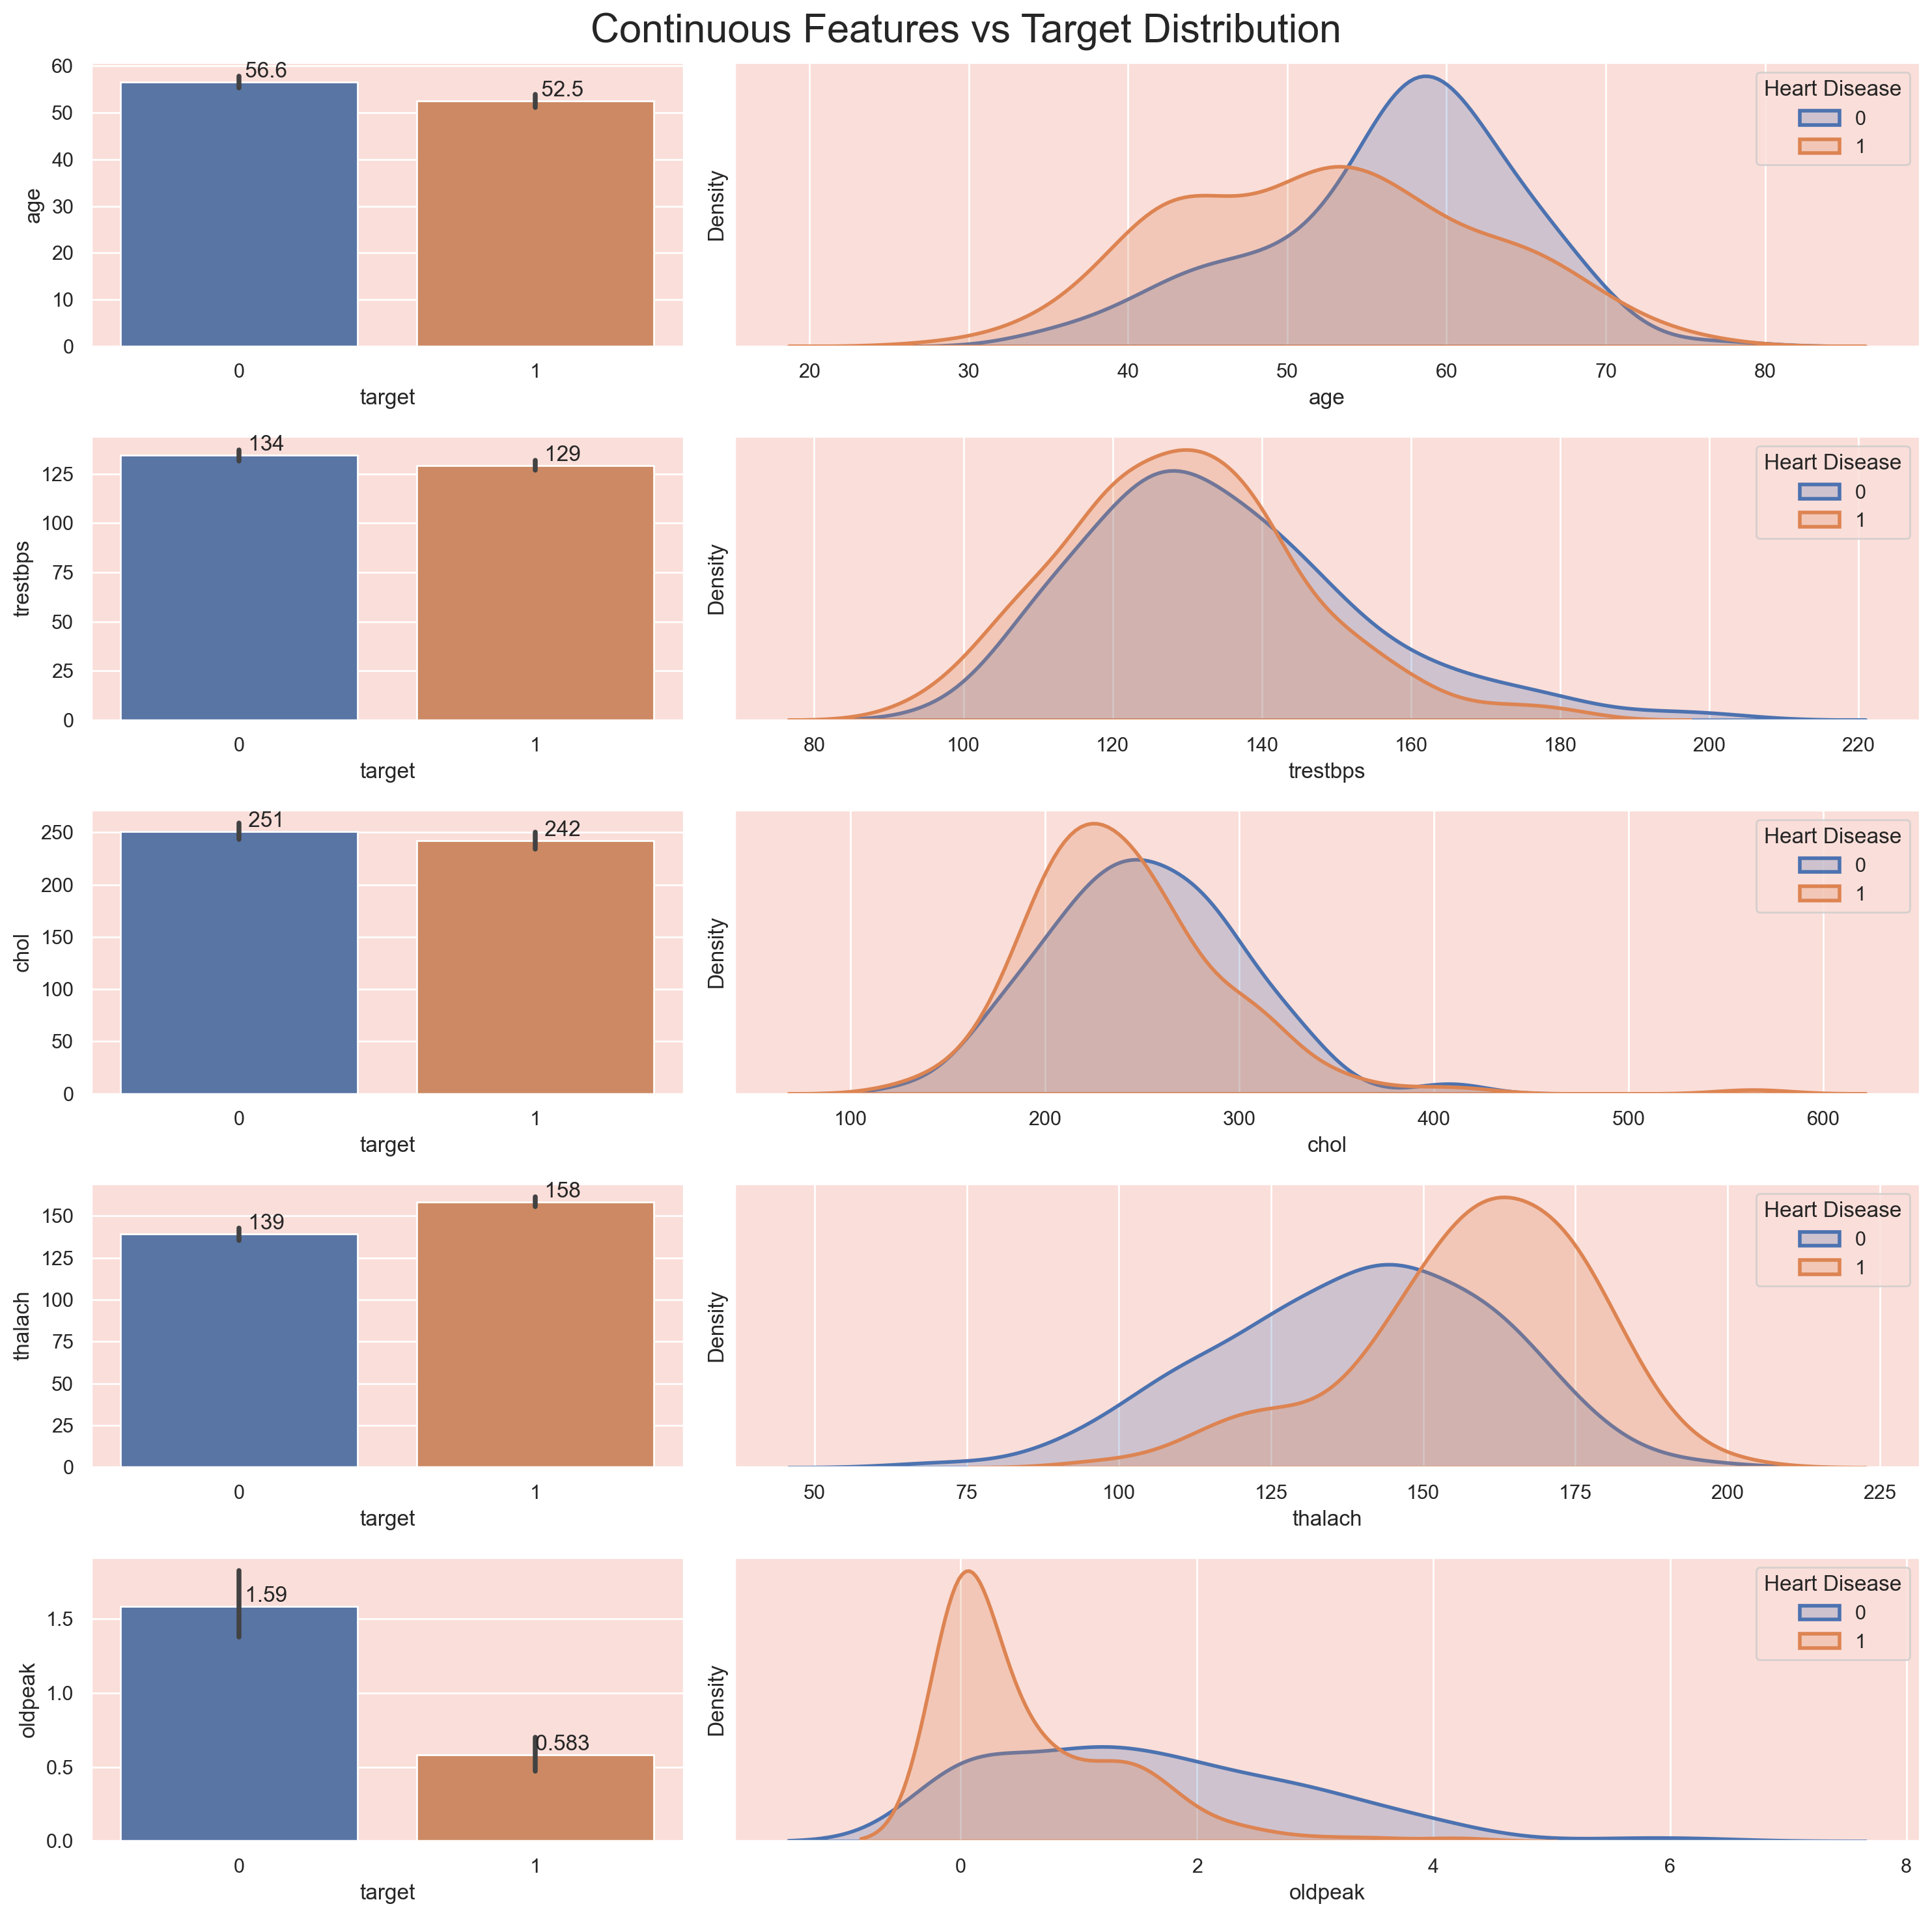

In [37]:
# Set color palette
#sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()


 __Age (`age`)__: The distributions show a slight shift with patients having heart disease being a bit younger on average than those without. The mean age for patients without heart disease is higher.
__Resting Blood Pressure (`trestbps`)__: Both categories display overlapping distributions in the KDE plot, with nearly identical mean values, indicating limited differentiating power for this feature.
__Serum Cholesterol (`chol`)__: The distributions of cholesterol levels for both categories are quite close, but the mean cholesterol level for patients with heart disease is slightly lower.
__Maximum Heart Rate Achieved (`thalach`)__: There's a noticeable difference in distributions. Patients with heart disease tend to achieve a higher maximum heart rate during stress tests compared to those without.
__ST Depression (`oldpeak`)__: The ST depression induced by exercise relative to rest is notably lower for patients with heart disease. Their distribution peaks near zero, whereas the non-disease category has a wider spread.  
Based on the visual difference in distributions and mean values, __Maximum Heart Rate (`thalach`)__ seems to have the most impact on the heart disease status, followed by __ST Depression (`oldpeak`)__ and __Age (`age`)__.

Categorical Features vs Target

I am going to display __100% stacked bar plots__ for each categorical feature illustrating the proportion of each category across the two target classes, complemented by the exact counts and percentages on the bars.

In [29]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

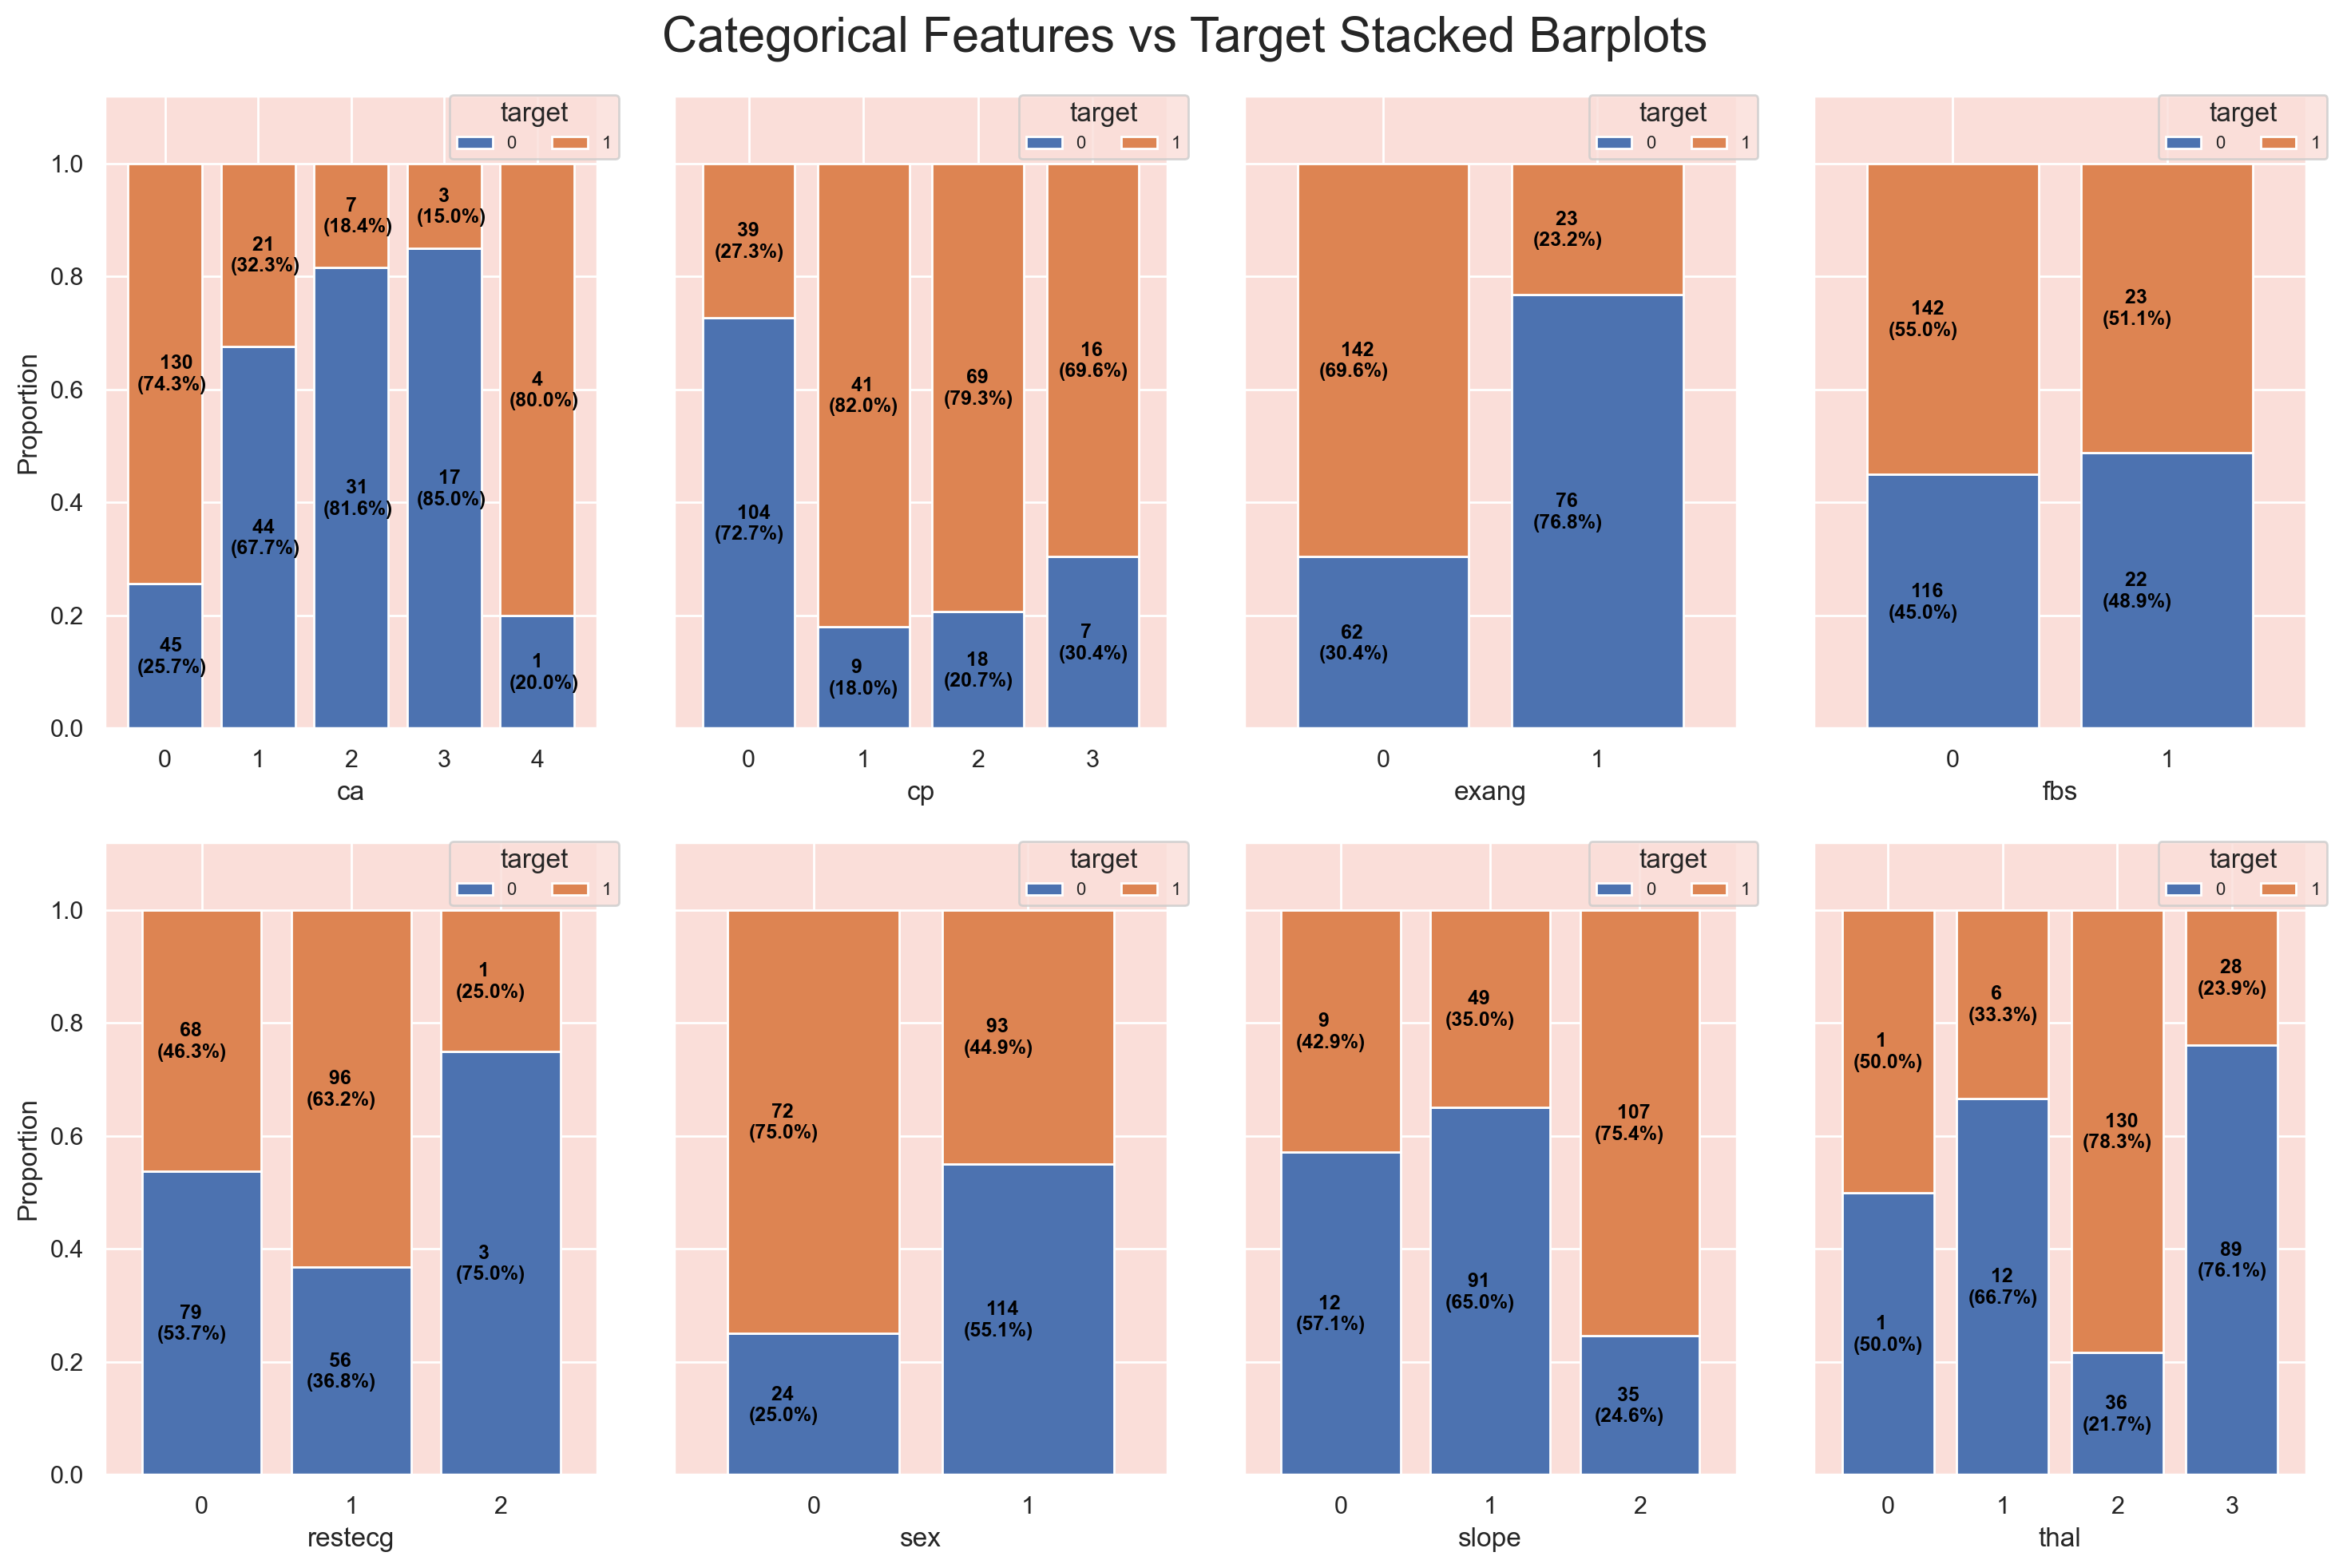

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of heartrate 0 and 1 for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03, s = f'    {count}\n({np.round(proportion * 100, 1)}%)', color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

__Number of Major Vessels (`ca`)__: The majority of patients with heart disease have fewer major vessels colored by fluoroscopy. As the number of colored vessels increases, the proportion of patients with heart disease tends to decrease. Especially, patients with 0 vessels colored have a higher proportion of heart disease presence.
 __Chest Pain Type (`cp`)__: Different types of chest pain present varied proportions of heart disease. Notably, types 1, 2, and 3 have a higher proportion of heart disease presence compared to type 0. This suggests the type of chest pain can be influential in predicting the disease.
 __Exercise Induced Angina (`exang`)__: Patients who did not experience exercise-induced angina (0) show a higher proportion of heart disease presence compared to those who did (1). This feature seems to have a significant impact on the target.
__Fasting Blood Sugar (`fbs`)__: The distribution between those with fasting blood sugar > 120 mg/dl (1) and those without (0) is relatively similar, suggesting `fbs` might have limited impact on heart disease prediction.
 __Resting Electrocardiographic Results (`restecg`)__: Type 1 displays a higher proportion of heart disease presence, indicating that this feature might have some influence on the outcome.
__Sex (`sex`)__: Females (1) exhibit a lower proportion of heart disease presence compared to males (0). This indicates gender as an influential factor in predicting heart disease.
__Slope of the Peak Exercise ST Segment (`slope`)__: The slope type 2 has a notably higher proportion of heart disease presence, indicating its potential as a significant predictor.
__Thalium Stress Test Result (`thal`)__: The reversible defect category (2) has a higher proportion of heart disease presence compared to the other categories, emphasizing its importance in prediction.

In summary, based on the visual representation:

* __Higher Impact on Target: `ca`, `cp`, `exang`, `sex`, `slope`, and `thal`__
* __Moderate Impact on Target: `restecg`__
* __Lower Impact on Target: `fbs`__

Irrelevant Features Removal

All features in the dataset appear to be relevant based on our __EDA__. No columns seem redundant or irrelevant. Thus, we'll retain all features, ensuring no valuable information is lost, especially given the dataset's small size.

Missing Value Treatment

In [40]:
# Check for missing values in the dataset
df.isnull().sum().sum()

0

Upon our above inspection, it is obvious that there are no missing values in our dataset. This is ideal as it means we don't have to make decisions about imputation or removal, which can introduce bias or reduce our already limited dataset size.

Outlier Treatment

I am going to check for outliers using the __IQR method__ for the continuous features:

In [41]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [42]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

Upon identifying outliers for the specified continuous features, we found the following:

* __`trestbps`__: 9 outliers
* __`chol`__: 5 outliers
* __`thalach`__: 1 outlier
* __`oldpeak`__: 5 outliers
* __`age`__: No outliers

Sensitivity to Outliers
 __SVM (Support Vector Machine)__: SVMs can be sensitive to outliers. While the decision boundary is determined primarily by the support vectors, outliers can influence which data points are chosen as support vectors, potentially leading to suboptimal classification.
 __Decision Trees (DT) and Random Forests (RF)__: These tree-based algorithms are generally robust to outliers. They make splits based on feature values, and outliers often end up in leaf nodes, having minimal impact on the overall decision-making process.
 __K-Nearest Neighbors (KNN)__: KNN is sensitive to outliers because it relies on distances between data points to make predictions. Outliers can distort these distances.
 __AdaBoost:__ This ensemble method, which often uses decision trees as weak learners, is generally robust to outliers. However, the iterative nature of AdaBoost can sometimes lead to overemphasis on outliers, making the final model more sensitive to them.

Approaches for Outlier Treatment
 __Removal of Outliers__: Directly discard data points that fall outside of a defined range, typically based on a method like the Interquartile Range (IQR).
 __Capping Outliers__: Instead of removing, we can limit outliers to a certain threshold, such as the 1st or 99th percentile.
 __Transformations__: Applying transformations like log or Box-Cox can reduce the impact of outliers and make the data more Gaussian-like.
 __Robust Scaling__: Techniques like the RobustScaler in Scikit-learn can be used, which scales features using statistics that are robust to outliers.

Given __the nature of the algorithms (especially SVM and KNN)__ and __the small size of our dataset__, direct removal of outliers might not be the best approach. Instead, __we'll focus on applying transformations like Box-Cox in the subsequent steps__ to reduce the impact of outliers and make the data more suitable for modeling.

 Categorical Features Encoding

One-hot Encoding Decision
    
Based on the feature descriptions, let's decide on one-hot encoding:

1. __Nominal Variables__: These are variables with no inherent order. They should be one-hot encoded because using them as numbers might introduce an unintended order to the model.

2. __Ordinal Variables__: These variables have an inherent order. They don't necessarily need to be one-hot encoded since their order can provide meaningful information to the model.

Given the above explanation:

- __`sex`__: This is a binary variable with two categories (male and female), so it doesn't need one-hot encoding.
- __`cp`__: Chest pain type can be considered as nominal because there's no clear ordinal relationship among the different types of chest pain (like Typical angina, Atypical angina, etc.). It should be one-hot encoded.
- __`fbs`__: This is a binary variable (true or false), so it doesn't need one-hot encoding.
- __`restecg`__: This variable represents the resting electrocardiographic results. The results, such as "Normal", "Having ST-T wave abnormality", and "Showing probable or definite left ventricular hypertrophy", don't seem to have an ordinal relationship. Therefore, it should be one-hot encoded.
- __`exang`__: This is a binary variable (yes or no), so it doesn't need one-hot encoding.
- __`slope`__: This represents the slope of the peak exercise ST segment. Given the descriptions (Upsloping, Flat, Downsloping), it seems to have an ordinal nature, suggesting a particular order. Therefore, it doesn't need to be one-hot encoded.
- __`ca`__: This represents the number of major vessels colored by fluoroscopy. As it indicates a count, it has an inherent ordinal relationship. Therefore, it doesn't need to be one-hot encoded.
- __`thal`__: This variable represents the result of a thalium stress test. The different states, like "Normal", "Fixed defect", and "Reversible defect", suggest a nominal nature. Thus, it should be one-hot encoded.

- __Need One-Hot Encoding__: __`cp`__, __`restecg`__, __`thal`__
- __Don't Need One-Hot Encoding__: __`sex`__, __`fbs`__, __`exang`__, __`slope`__, __`ca`__

In [43]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [44]:
# Displaying the resulting DataFrame after one-hot encoding
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


__Feature Scaling__ is a crucial preprocessing step __for algorithms that are sensitive to the magnitude or scale of features__. Models like __SVM__, __KNN__, and many linear models rely on distances or gradients, making them susceptible to variations in feature scales. __Scaling ensures that all features contribute equally to the model's decision rather than being dominated by features with larger magnitudes.__
____

While feature scaling is vital for some models, not all algorithms require scaled data. For instance, __Decision Tree-based models__ are scale-invariant. Given our intent to use a mix of models (some requiring scaling, others not), __we've chosen to handle scaling later using pipelines__. This approach lets us apply scaling specifically for models that benefit from it, ensuring flexibility and efficiency in our modeling process.


 Transforming Skewed Features

__Box-Cox__ transformation is a powerful method to stabilize variance and make the data more normal-distribution-like. It's particularly useful when you're unsure about the exact nature of the distribution you're dealing with, as it can adapt itself to the best power transformation. However, the Box-Cox transformation only works for positive data, so one must be cautious when applying it to features that contain zeros or negative values.

Transforming Skewed Features & Data Leakage Concerns:
    
When preprocessing data, especially applying transformations like the Box-Cox, it's essential to be wary of __data leakage__. __Data leakage__ refers to a mistake in the preprocessing of data in which information from outside the training dataset is used to transform or train the model. This can lead to overly optimistic performance metrics.

To avoid data leakage and ensure our model generalizes well to unseen data:

__1- Data Splitting:__ We'll first split our dataset into a training set and a test set. This ensures that we have a separate set of data to evaluate our model's performance, untouched during the training and preprocessing phases.

__2- Box-Cox Transformation:__ We'll examine the distribution of the continuous features in the training set. If they appear skewed, we'll apply the Box-Cox transformation to stabilize variance and make the data more normal-distribution-like. Importantly, we'll determine the Box-Cox transformation parameters solely based on the training data.

__3- Applying Transformations to Test Data:__ Once our transformation parameters are determined from the training set, we'll use these exact parameters to transform our validation/test set. This approach ensures that no information from the validation/test set leaks into our training process.

__4. Hyperparameter Tuning & Cross-Validation:__ Given our dataset's size, to make the most of the available data during the model training phase, we'll employ __cross-validation on the training set for hyperparameter tuning__. This allows us to get a better sense of how our model might perform on unseen data, without actually using the test set. The test set remains untouched during this phase and is only used to evaluate the final model's performance.


By following this structured approach, we ensure a rigorous training process, minimize the risk of data leakage, and set ourselves up to get a realistic measure of our model's performance on unseen data.

In [45]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [46]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [47]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

The Box-Cox transformation requires all data to be strictly positive. To transform the `oldpeak` feature using Box-Cox, we can add a small constant (e.g., 0.001) to ensure all values are positive:

In [48]:
# Adding a small constant to 'oldpeak' to make all values positive
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

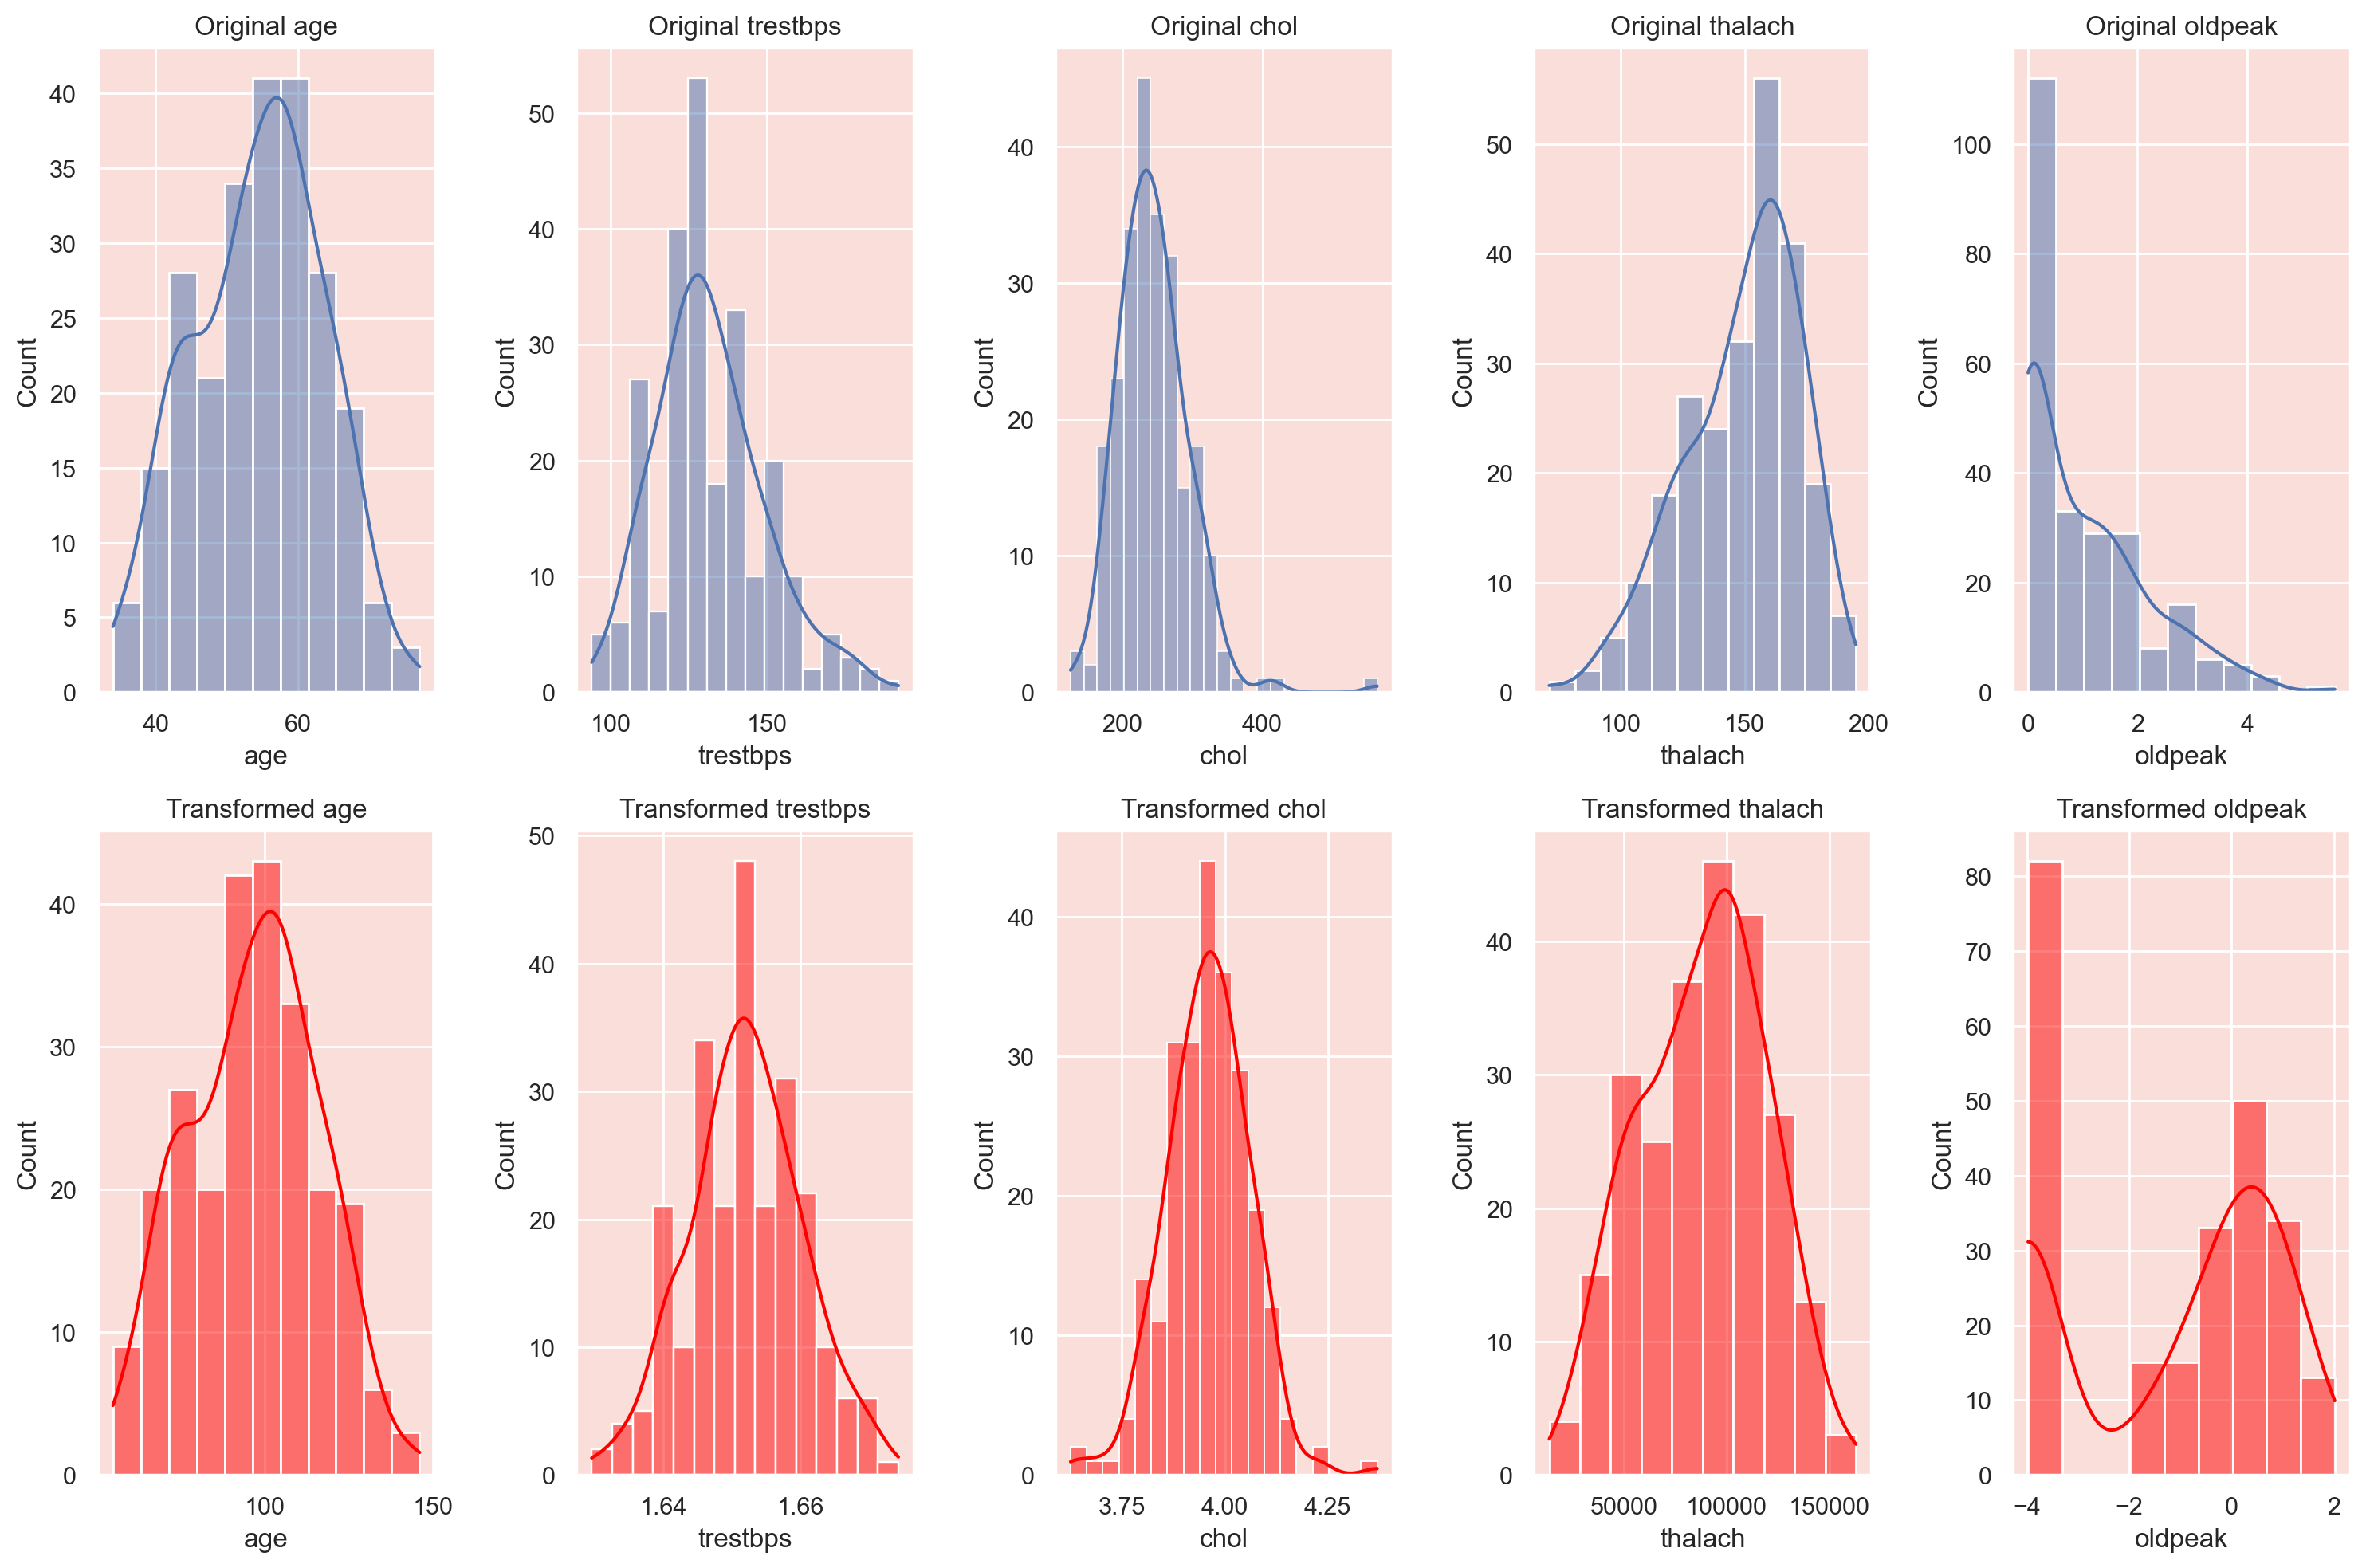

In [49]:
# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15,10))

# Original Distributions
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i]).set_title(f'Original {col}')
    

# Applying Box-Cox Transformation
# Dictionary to store lambda values for each feature
lambdas = {}

for i, col in enumerate(continuous_features):
    # Only apply box-cox for positive values
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        # Applying the same lambda to test data
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col]) 
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'Transformed {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

Inference:
__1- `age`__: The transformation has made the `age` distribution more symmetric, bringing it closer to a normal distribution.

__2- `Trestbps`__: The distribution of `trestbps` post-transformation appears to be more normal-like, with reduced skewness.

__3- `Chol`__: After applying the Box-Cox transformation, `chol` exhibits a shape that's more aligned with a normal distribution.

__4- `Thalach`__: The `thalach` feature was already fairly symmetric before the transformation, and post-transformation, it continues to show a similar shape, indicating its original distribution was close to normal.

__5- `Oldpeak`__: The transformation improved the `oldpeak` distribution, but it still doesn't perfectly resemble a normal distribution. This could be due to the inherent nature of the data or the presence of outliers. To enhance its normality, we could consider utilizing advanced transformations such as the Yeo-Johnson transformation, which can handle zero and negative values directly.

Transforming features to be more normal-like primarily helps in mitigating the impact of outliers, which is particularly beneficial for distance-based algorithms like __SVM__ and __KNN__. By reducing the influence of __outliers__, we ensure that these algorithms can compute distances more effectively and produce more reliable results.

In [50]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775303,1,1.652121,4.044510,1,34193.175862,1,0.490856,0,0,False,False,False,False,False,False,False,True
191,104.060224,1,1.651136,3.909224,0,61564.541974,1,0.846853,1,3,False,False,False,False,False,False,False,True
15,87.096543,0,1.646937,3.916242,0,97354.732537,0,0.490856,1,0,False,True,False,True,False,False,True,False
224,95.519131,1,1.641028,3.960430,0,55975.802227,1,1.130195,1,1,False,False,False,True,False,False,False,True
250,89.190680,1,1.656716,4.069854,0,51729.405015,1,1.634849,1,3,False,False,False,True,False,False,False,True


Decision Tree Model Building

In [51]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

 DT  Hyperparameter Tuning

In medical scenarios, especially in the context of diagnosing illnesses, it's often more important __to have a high recall (sensitivity) for the positive class (patients with the condition).
A high recall ensures that most of the actual positive cases are correctly identified, even if it means some false positives (cases where healthy individuals are misclassified as having the condition). The rationale is that it's generally better to have a few false alarms than to miss out on diagnosing a patient with a potential illness.

I am establishing a function to determine the optimal set of hyperparameters that yield the highest __recall__ for the model. This approach ensures a reusable framework for hyperparameter tuning of subsequent models:

In [52]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

I'll set up the hyperparameters grid and utilize the __tune_clf_hyperparameters__ function to pinpoint the optimal hyperparameters for our DT model:

In [53]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [54]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [55]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


DT Model Evaluation

Now let's evaluate our DT model performance on both the training and test datasets:

In [56]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [57]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



Given that the metric values for both the training and test datasets are closely aligned and not significantly different, the model doesn't appear to be overfitting.
Let's create a function that consolidates each model's metrics into a dataframe, facilitating an end-to-end comparison of all models later:


In [58]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

In [59]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.8,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79


Random Forest Model Building

In [60]:
rf_base = RandomForestClassifier(random_state=0)

RF Hyperparameter Tuning
    
Afterward, I am setting up the hyperparameters grid and utilize the __tune_clf_hyperparameters__ function to pinpoint the optimal hyperparameters for our RF model:

In [61]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [62]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


RF Model Evaluation
Finally, I am evaluating the model's performance on both the training and test datasets:

In [63]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [64]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61




The RF model's similar performance on both training and test data suggests it isn't overfitting.

In [65]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84


 KNN Model Building
First of all, let's define the base KNN model and set up the pipeline with scaling:

In [66]:
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


I'll set up the hyperparameters grid and utilize the __tune_clf_hyperparameters__ function to pinpoint the optimal hyperparameters for our KNN pipeline:

In [67]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [68]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)


KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


In [71]:
print(best_knn)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9, p=1))])



Let's evaluate the model's performance on both the training and test datasets:

In [69]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       110
           1       0.83      0.83      0.83       132

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242



In [70]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



The KNN model's consistent scores across training and test sets indicate no overfitting.

In [72]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


SVM Model Building
First, let's define the base SVM model and set up the pipeline with scaling:

In [73]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

Let's configure the hyperparameters grid and employ the __tune_clf_hyperparameters__ function to determine the best hyperparameters for our SVM pipeline:

In [74]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [75]:
# Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}



Let's evaluate our SVM model's performance on both the training and test datasets:

In [76]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.54      0.68       110
           1       0.71      0.96      0.82       132

    accuracy                           0.77       242
   macro avg       0.82      0.75      0.75       242
weighted avg       0.81      0.77      0.76       242



In [77]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71        28
           1       0.73      0.97      0.83        33

    accuracy                           0.79        61
   macro avg       0.83      0.77      0.77        61
weighted avg       0.83      0.79      0.78        61



 Inference:

The __recall of 0.97 for class 1__ indicates that almost all the __true positive cases (i.e., patients with heart disease)__ are correctly identified. This high recall is of utmost importance in a medical context, where missing a patient with potential heart disease could have dire consequences.

However, it's also worth noting the balanced performance of the model. With an __F1-score of 0.83 for class 1__, it's evident that the model doesn't merely focus on maximizing recall at the expense of precision. This means the reduction in False Negatives hasn't significantly increased the False Positives, ensuring that the cost and effort of examining healthy individuals are not unnecessarily high.

Overall, the model's performance is promising for medical diagnostics, especially when prioritizing the accurate identification of patients with heart disease without overburdening the system with false alarms.

In [78]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79


Conclusion
In the critical context of diagnosing heart disease, our primary objective is __to ensure a high recall for the positive class__. 
It's important to accurately identify every potential heart disease case, as even one missed diagnosis could have large implications.
 However, while striving for this high recall, it's essential to maintain a balanced performance to avoid unnecessary medical interventions for healthy individuals. We'll now evaluate our models against these crucial medical benchmarks.



In [79]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'recall_1'
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.94,0.73,0.57,0.97,0.71,0.83,0.83,0.77,0.77,0.79
RF,0.85,0.83,0.79,0.88,0.81,0.85,0.84,0.83,0.83,0.84
DT,0.80,0.78,0.71,0.85,0.75,0.81,0.79,0.78,0.78,0.79
KNN,0.82,0.85,0.82,0.85,0.82,0.85,0.83,0.83,0.83,0.84


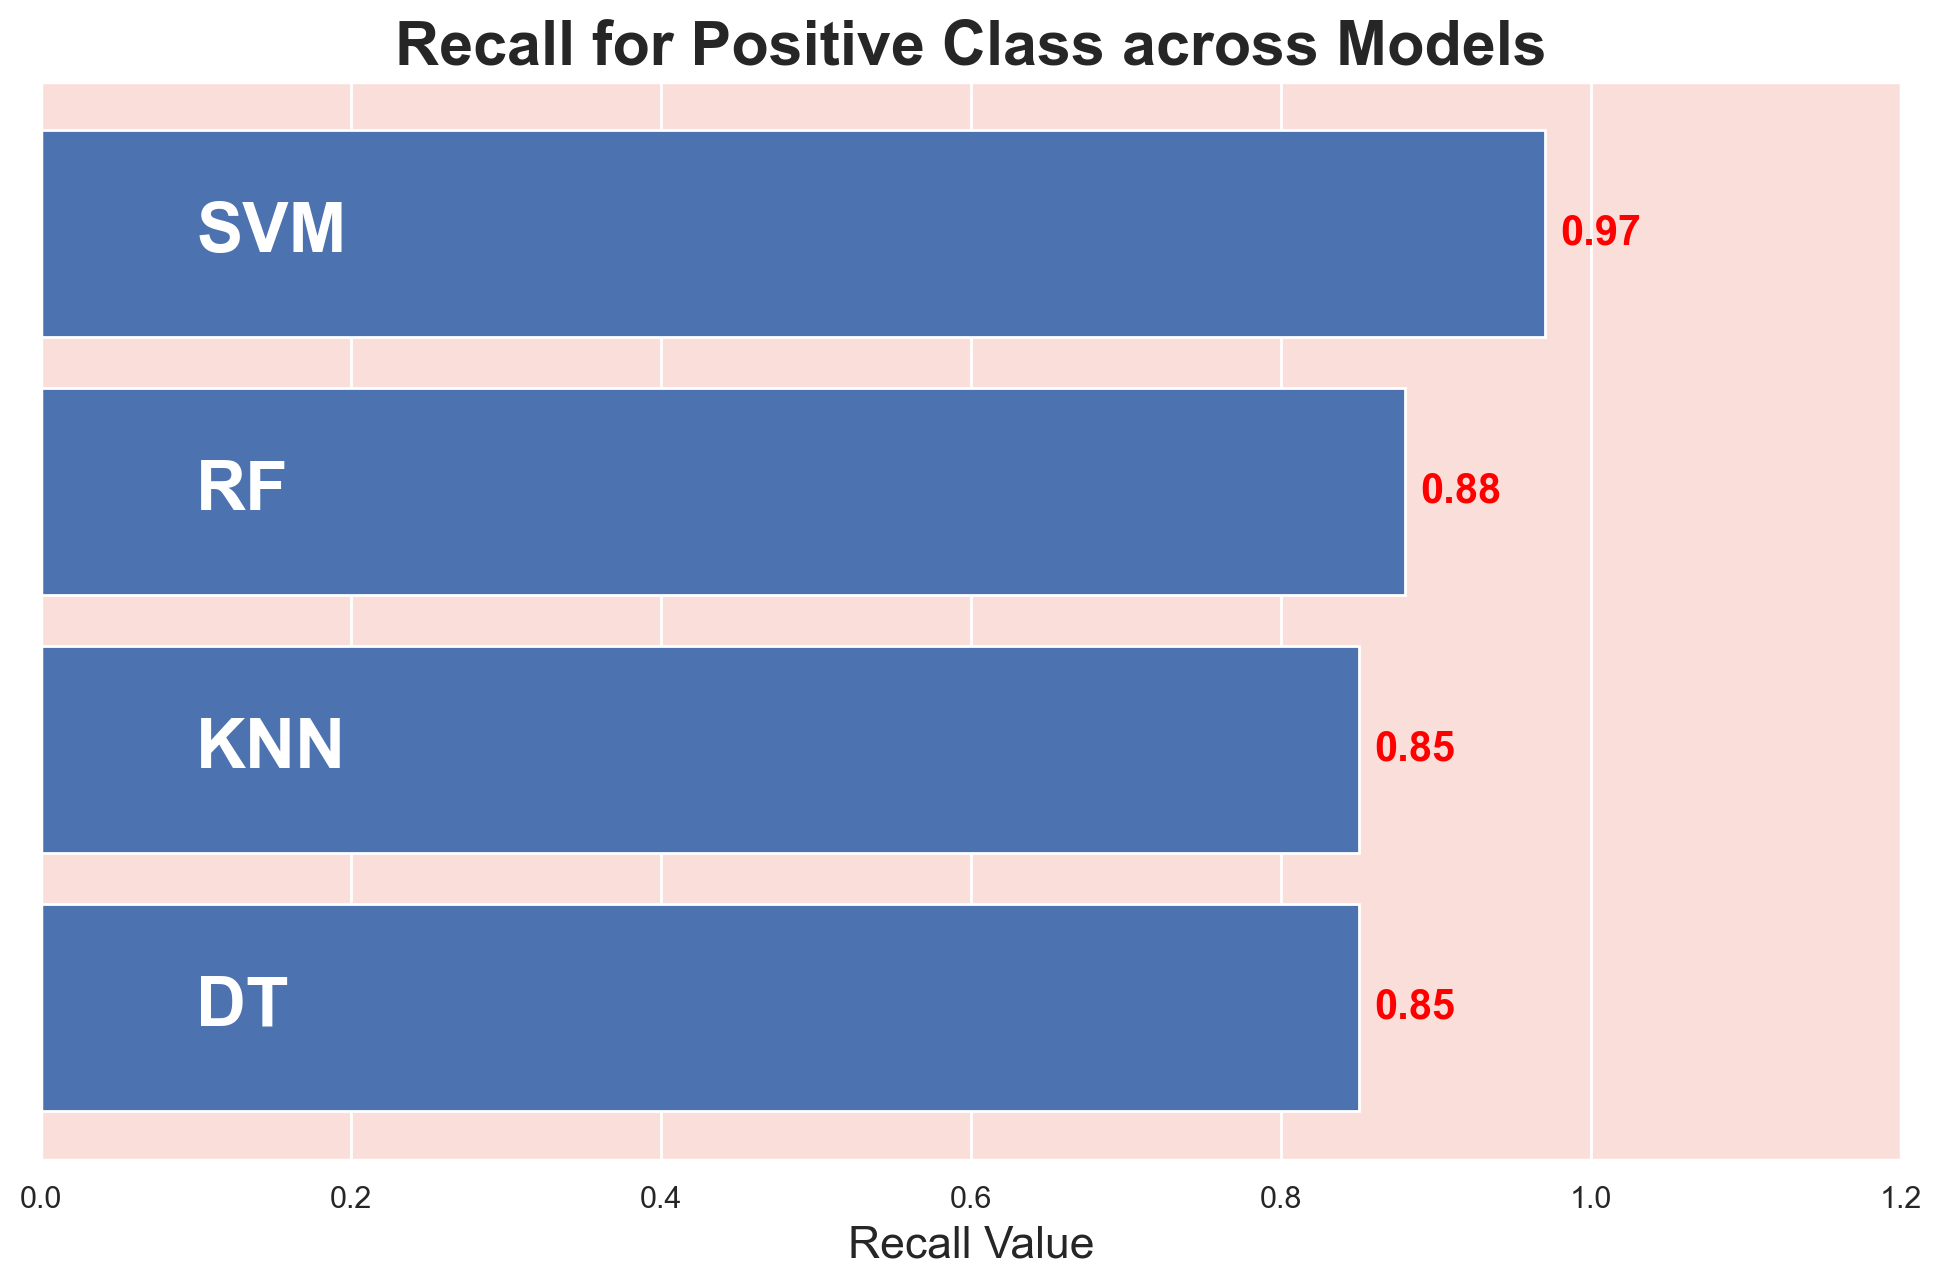

In [80]:
# Sort values based on 'recall_1'
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(results.index, recall_1_scores)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.2])

# Add title and xlabel
plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel('Recall Value', fontsize=16)
plt.show()

Hence, The SVM model demonstrates a commendable capability in recognizing potential heart patients. With a recall of 0.97 for class 1, it's evident that almost all patients with heart disease are correctly identified. This is of paramount importance in a medical setting. However, the model's balanced performance ensures that while aiming for high recall, it doesn't compromise on precision, thereby not overburdening the system with unnecessary alerts.

